# Imports

In [1]:

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
import time

In [2]:
from pylab import *
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse

# Set values

In [3]:
k = 0.5 #value for k
num_params = 2 #number of paramaeters to constrain

In [4]:
# few lines to determine dimensions needed to hold data
pk = np.loadtxt('/mnt/ceph/users/fvillaescusa/Ana/matter/latin_hypercube/%d/Pk_m_z=0.txt'%0) 
mask = pk[:,0] <=k
values =pk[mask]
dim = values.shape
dim

(79, 2)

# Get the data

In [5]:
var_data =  np.zeros((2000,dim[0],dim[1]), dtype=float)
ncv_data =  np.zeros((2000,dim[0],dim[1]), dtype=float)
labels = np.zeros((2000,num_params), dtype=float)

for i in np.random.choice(2000,2000, replace=False):
    pk = np.loadtxt('/mnt/ceph/users/fvillaescusa/Ana/matter/latin_hypercube/%d/Pk_m_z=0.txt'%i)
    mask = pk[:,0] <=k
    pk_new = pk[mask]
    pk_ncv = np.loadtxt('/mnt/ceph/users/fvillaescusa/Ana/matter/latin_hypercube/NCV_0_%d/Pk_m_z=0.txt'%i)
    mask_ncv = pk_ncv[:,0] <=k
    pk_ncv_new = pk_ncv[mask_ncv]
    cosmo_params = np.loadtxt('/mnt/ceph/users/fvillaescusa/Ana/latin_hypercube/latin_hypercube_params.txt')[i]
    var_data[i]=(pk_new)
    ncv_data[i]=(pk_ncv_new)
    labels[i]=cosmo_params[[0,4]]

In [6]:
var= var_data.reshape(len(var_data),-1) #reshape the data vector for Renadom Forest Regressor

In [7]:
var.shape

(2000, 158)

In [8]:
ncv= ncv_data.reshape(len(ncv_data),-1) #reshape the data vector for Renadom Forest Regressor

In [9]:
ncv.shape

(2000, 158)

# train/test check 
(Checks for high variance)

In [11]:
def checktraintestreg(model, ntrials =5):

    scores_train = np.zeros(ntrials)
    scores_test = np.zeros(ntrials)

    for i in range(ntrials):
        model.fit(var, labels)
        pred_test = model.predict(ncv)
        pred_train = model.predict(var)

        scores_test[i] = (metrics.r2_score(labels,pred_test))
        scores_train[i] =(metrics.r2_score(labels,pred_train))

    print('Training scores '+str(scores_train.mean())+' +- '+str(scores_train.std()))
    print('Test scores '+str(scores_test.mean())+' +- '+str(scores_test.std()))

In [12]:
checktraintestreg(RandomForestRegressor(n_estimators=20, min_samples_leaf=10))

Training scores 0.9561418837150251 +- 0.000537926293274924
Test scores 0.9378955051223908 +- 0.000779291062083026


In [13]:
checktraintestreg(RandomForestRegressor(n_estimators=100, min_samples_leaf=10))

Training scores 0.9578890166407057 +- 0.0001517281454755964
Test scores 0.9398845586999469 +- 0.00028970821399129925


In [14]:
checktraintestreg(RandomForestRegressor(n_estimators=100, min_samples_leaf=5))

Training scores 0.9762001608241903 +- 0.00016638657446665657
Test scores 0.9501693767309124 +- 0.00021647653551082755


In [15]:
checktraintestreg(RandomForestRegressor(n_estimators=100, max_depth= 5, min_samples_leaf=5))

Training scores 0.92199734280826 +- 0.0002823999310615918
Test scores 0.9127902046990742 +- 0.0002955929297382199


In [16]:
checktraintestreg(RandomForestRegressor(n_estimators=200, min_samples_leaf=5))

Training scores 0.9764765484645539 +- 6.55094260163582e-05
Test scores 0.9505112695706611 +- 0.00015642046464570377


# Train the model

In [17]:
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, n_jobs= 5)

In [18]:
start= time.time()

model.fit(var, labels)

print('Time (s):', "{:.4f}".format((time.time()-start)))

Time (s): 1.4210


In [19]:
ypred=model.predict(ncv)

# Results

In [20]:
def obtain_cosmo_params_rmse(test_data, prediction_data, title):
    scores={}
    #maxmin={}
    om_score =np.sqrt(metrics.mean_squared_error(test_data[:,0],prediction_data[:,0]))
    s8_score =np.sqrt(metrics.mean_squared_error(test_data[:,1],prediction_data[:,1]))
    scores.update([('omega m rmse', om_score)])
    scores.update([('sigma 8 rmse', s8_score)])
    np.save(title, scores)
    
    #maxmin.update([(('omega m min', np.min(prediction_data[:,0])), ('omega m max', np.max(prediction_data[:,0])))])
    #maxmin.update([(('sigma 8 min', np.min(prediction_data[:,1])), ('sigma 8 max', np.max(prediction_data[:,1])))])
    
    return scores, #maxmin

In [22]:
obtain_cosmo_params_rmse(labels, ypred, 'RF_Var_NCV_Pk_0.5_scores_12_23')

({'omega m rmse': 0.0356327028281527, 'sigma 8 rmse': 0.007177508391795007},)

Text(0.5, 0.98, 'RF_Train:Quijote_Satndard_Test:Quijote_NCV_z=0_Pk_k<=0.5')

<Figure size 432x288 with 0 Axes>

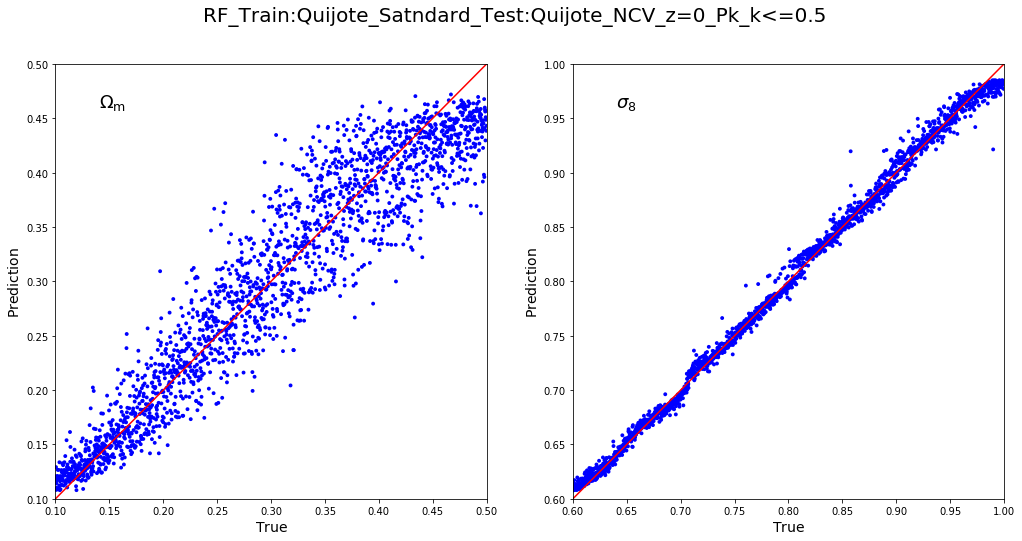

In [26]:
fig = figure()
fig = figure(figsize=(17,8))     #give dimensions to the figure

#gs =  gridspec.GridSpec(2,3height_ratios=[1,1,1],width_ratios[1,1])
gs =  gridspec.GridSpec(1,2)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
#ax3 = plt.subplot(gs[2])
#ax4 = plt.subplot(gs[3])
#ax5 = plt.subplot(gs[4])
#ax6 = plt.subplot(gs[5])

x_min, x_max = 0.1, 0.5
y_min, y_max = 0.1, 0.5

#param_min = [0.1, 0.03, 0.5, 0.8, 0.6]
#param_max = [0.5, 0.07, 0.9, 1.2, 1.0]

param_min = [0.1, 0.6]
param_max = [0.5, 1.0]

#label = [r"$\Omega_{\rm m}$", r"$\Omega_{\rm b}$", r"$h$",
         #r"$n_{\rm s}$", r"$\sigma_8$"]

label = [r"$\Omega_{\rm m}$", r"$\sigma_8$"]

x_dumb = np.linspace(-5,5,100) 


for i,ax in enumerate([ax1,ax2]):

    ax.set_xlim([param_min[i],param_max[i]])
    ax.set_ylim([param_min[i],param_max[i]])
    #ax.set_xlim([np.min(true_values[:,i]), np.max(true_values[:,i])]) #for plotting the ouliers
    #ax.set_ylim([1.05*np.min(pred_values[:,i]), 1.05*np.max(pred_values[:,i])]) #for plotting the outliers


    ax.set_xlabel(r'${\rm True}$',fontsize=14)
    ax.set_ylabel(r'${\rm Prediction}$',fontsize=14)

    p1=ax.scatter(labels[:,i], ypred[:,i],c='b',edgecolor='none',s=15,marker='o', )
    ax.plot(x_dumb, x_dumb, linestyle='-', c='r')
    
    posx = param_min[i] + 0.1*(param_max[i] - param_min[i])
    posy = param_min[i] + 0.9*(param_max[i] - param_min[i])
    ax.text(posx, posy, label[i], size=18)
    
    #ax.legend(loc='lower right')



suptitle('RF_Train:Quijote_Satndard_Test:Quijote_NCV_z=0_Pk_k<=0.5', fontsize=20)  #for title with several panels

#savefig('/Pk_Quijote/RF_QUIJOTE_var_ncv_k05_12_23.pdf', bbox_inches='tight')